<h4>Installieren aller Bibliotheken</h4>
Da die Notebooks in einem Container ausgeführt werden, muss dies in dem Notebook passieren.

In [ ]:
%%capture
pip install pytorch-lightning

In [ ]:
%%capture
pip install pytorch-gradcam

In [ ]:
%%capture
pip install grad-cam

In [ ]:
%%capture
!pip install "opencv-python-headless<4.3"

In [ ]:
%%capture
pip install tqdm

In [ ]:
%%capture
pip install wandb

<h4>Importieren aller verwendeten Pakete</h4>

In [ ]:
#Import
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import os
import math
import torchvision
from torchvision import datasets, transforms
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import random
import pytorch_lightning as pl
from torch.nn import Parameter
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.sobel_cam import sobel_cam
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
import tqdm

cuda


In [ ]:
#seed everything
seed = 100
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

Einloggen in Weights and Biases (Wandb)

In [ ]:
import wandb
wandb.login()

wandb: Currently logged in as: nbennewiz. Use `wandb login --relogin` to force relogin


True

<h4>Preprocessing and Augmentation</h4>

In [ ]:
#implements the pseudo-color-enhancement-function
#Implementiert eine nicht-lineare oder lineare Funktion zum Pseudo-Color-Enhancement
#Als Default ist die vorgestellte Magma-Funktion ausgewählt. 
#Die Funktionen werden von Matplotlib genommen. Es können sich weitere verschiedene Funktionen hier gefunden werden: https://matplotlib.org/stable/tutorials/colors/colormaps.html
def colorMapping(x, name_map="magma"):
    cm = plt.get_cmap(name_map)

    x_map1 = cm(x[ 0, :, :,].detach().numpy())
    
    x_map2 = torch.Tensor(x_map1[ :, :, :3]).to(torch.float).transpose(-2, -1).transpose(0, 1)

    return x_map2

In [ ]:
#function to add gaussian noise, because pytorch does not have one, just for gaussian blur
#Da PyTorch bzw. Torchvision keine Funktionen haben um eine Gaußsche Unschärfe auf die Bilder zu geben, wir diese hier implementiert
def gauss_noise_tensor(img):
    assert isinstance(img, torch.Tensor)
    dtype = img.dtype
    if not img.is_floating_point():
        img = img.to(torch.float32)
    
    sigma = (0.1**1)
    
    out = img + sigma * torch.randn_like(img)
    
    if out.dtype != dtype:
        out = out.to(dtype)
        
    return out

In [ ]:
#Es wird hier die Transforms-Funktion von Torchvision genutzt, die über jedes Bild, welches im DataLoader geladen wird rübergeht und transformiert.
#Die Transformation besteht aus:
#   dem Ändern der Bild-Größe, 
#   dem Zuschneiden des Bildes, sodass das Gehirn in der Mitte liegt, 
#   dem Ändern des Datentyps zu einem Tensor, sodass das Modell die Daten verarbeiten kann 
#   und dem Pseudo-Color-Enhancement
transform_normal = transforms.Compose([transforms.Resize(224),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                colorMapping
                               ])

In [ ]:

#Im folgenden werden die Daten geladen und dabei wird die Transforms-Funktion auf sie angewendet. Zudem werden sie so weiterverarbeitet, dass sie in einen DataLoader gegeben werden können
#Laden der Scans einer Klasse
dataset_nonDemented = datasets.ImageFolder("../Alzheimer/Dataset2/NonDemented/", transform=transform_normal)
#Es wird gezählt, wie viele Bilder es in dieser Klasse gibt
num_nonDemented = len(os.listdir(path="./Dataset2/NonDemented/NonDemented"))
#Es werden Labels für diese Bilder erstellt
labels_nonDemented = [np.array([1,0,0,0])] * num_nonDemented
#Es werden die automatisch beim Laden der Daten erstellten Labels mit den selber erstellten Labels ausgetauscht
dataset_nonDemented.targets = labels_nonDemented

#Dies wird für alle 4 Klassen wiederholt
#VeryMildDemented
dataset_veryMildDemented = datasets.ImageFolder("../Alzheimer/Dataset2/VeryMildDemented/", transform=transform_normal)
num_veryMildDemented = len(os.listdir(path="./Dataset2/VeryMildDemented/VeryMildDemented"))
labels_veryMildDemented = [np.array([0,1,0,0])] * num_veryMildDemented
dataset_veryMildDemented.targets = labels_veryMildDemented

#MildDemented
dataset_mildDemented = datasets.ImageFolder("../Alzheimer/Dataset2/MildDemented/", transform=transform_normal)
num_mildDemented = len(os.listdir(path="./Dataset2/MildDemented/MildDemented"))
labels_mildDemented = [np.array([0,0,1,0])] * num_mildDemented
dataset_mildDemented.targets = labels_mildDemented

#ModerateDemented
dataset_moderateDemented = datasets.ImageFolder("../Alzheimer/Dataset2/ModerateDemented/", transform=transform_normal)
num_moderateDemented = len(os.listdir(path="./Dataset2/ModerateDemented/ModerateDemented"))
labels_moderateDemented = [np.array([0,0,0,1])] * num_moderateDemented
dataset_moderateDemented.targets = labels_moderateDemented

#Es werden alle Bilder mit ihren Labels in eine Liste gegeben, um die Daten weiterzuverarbeiten
#Dies ist wichtig für das Erstellen von Trainings-, Validation- und Test-Set
train_data = []
for i in range(num_nonDemented):
    train_data.append([dataset_nonDemented[i][0], labels_nonDemented[i]])
for i in range(num_veryMildDemented):
    train_data.append([dataset_veryMildDemented[i][0], labels_veryMildDemented[i]])
for i in range(num_mildDemented):
    train_data.append([dataset_mildDemented[i][0], labels_mildDemented[i]])
for i in range(num_moderateDemented):
    train_data.append([dataset_moderateDemented[i][0], labels_moderateDemented[i]])

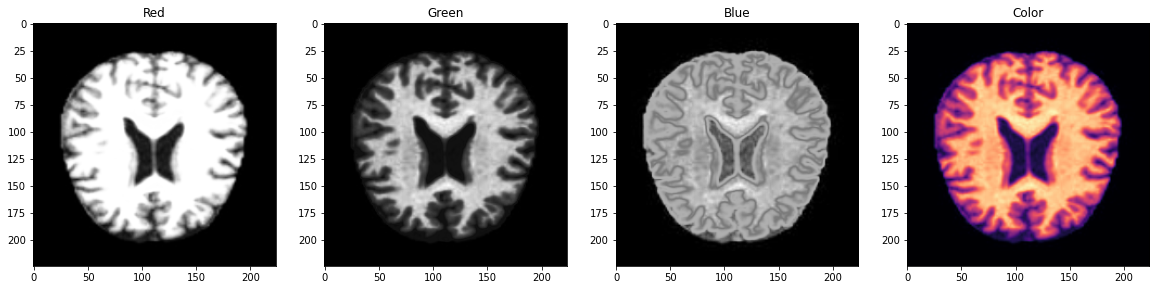

In [15]:
#Show that the noise gets applied to all layer
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
plt.gray()
ax[0].title.set_text('Red')
ax[0].imshow(train_data[0][0][0])
ax[1].title.set_text('Green')
ax[1].imshow(train_data[0][0][1])
ax[2].title.set_text('Blue')
ax[2].imshow(train_data[0][0][2])
ax[3].title.set_text('Color')
ax[3].imshow(train_data[0][0].transpose(0, 1).transpose(1, 2)[:, :, :3])

In [ ]:
#die Daten in der Liste werden durchmischt 
random.shuffle(train_data)

#Die Trainingsdaten werden in Test- und Trainingsdaten geteilt
test_slice = 0.1 #20%
test_data = train_data[0:int(len(train_data) * test_slice)]
train_data = train_data[int(len(train_data) * test_slice):]

#Die Trainingsdaten werden in Validation- und Trainingsdaten geteilt
val_slice = 0.15 #20%
val_data = train_data[0:int(len(train_data) * val_slice)]
train_data = train_data[int(len(train_data) * val_slice):]

#Ausgeben der Länge der einzelnen Sets
print("Length of training-data: ", len(train_data))
print("Length of validation-data: ",len(val_data))
print("Length of test-data: ", len(test_data))

#Die Trainings-, Validation- und Testdaten werden in einen DataLoader erstellt, der diese nochmal durchmischt und Batches mit einer vorgegebenen Größe erstellt
batch_size = 64
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=True, drop_last = True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, drop_last = True)

Length of training-data:  4896
Length of validation-data:  864
Length of test-data:  640


In [ ]:
#Funktion um RGB-Bilder wieder zurück in Grau-Bilder zu verwandeln
def rgb2gray(rgb):
    rgb = rgb.transpose(0, 1).transpose(1, 2)
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

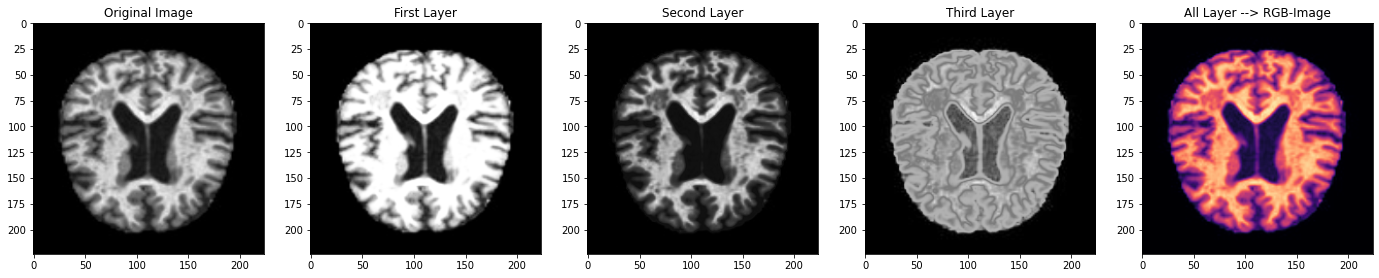

In [ ]:
#Es wird das erste Mal auf alle Layer, welche durch das Pseudo-Color-Enhancement enstanden sind, geguckt
#Es wird ein zufälliges Bild aus dem Test-Loader ausgewählt und angezeigt
random_num = random.randint(0, batch_size)

inp_data, labels = next(iter(test_loader))

fig, ax = plt.subplots(1, 5)
fig.set_size_inches(24, 24)
plt.gray()

ax[0].title.set_text('Original Image')
ax[0].imshow(rgb2gray(inp_data[random_num]))

ax[1].title.set_text('First Layer')
ax[1].imshow(inp_data[random_num][0])

ax[2].title.set_text('Second Layer')
ax[2].imshow(inp_data[random_num][1])

ax[3].title.set_text('Third Layer')
ax[3].imshow(inp_data[random_num][2])

ax[4].title.set_text('All Layer --> RGB-Image')
ax[4].imshow(inp_data[random_num].transpose(0, 1).transpose(1, 2)[:, :, :3])

<h4>Modell</h4>
Im Folgenden wird das Modell und seine Einzelteile gebaut und erklärt

In [19]:
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        #init convolutional layers
        self.conv1 = nn.Conv2d(3, 16, 2, 2)#3 input_layers, 16 output_layers, 3 kernel size, 2 step size
        self.conv2 = nn.Conv2d(16, 32, 2, 2)#16 input_layers, 32 output_layers, 3 kernel size, 2 step size
        self.conv3 = nn.Conv2d(32, 64, 2, 2)#32 input_layers, 64 output_layers, 3 kernel size, 2 step size
        self.conv4 = nn.Conv2d(64, 128, 2, 2)#64 input_layers, 256 output_layers, 3 kernel size, 2 step size

        #init batch normalization
        self.norm1 = nn.BatchNorm2d(16, affine=True)#affine= True means with learnable parameters
        self.norm2 = nn.BatchNorm2d(32, affine=True)#affine= True means with learnable parameters
        self.norm3 = nn.BatchNorm2d(64, affine=True)#affine= True means with learnable parameters
        self.norm4 = nn.BatchNorm2d(128, affine=True)#affine= True means with learnable parameters
        
        self.downsample1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(16)
        )
        
        self.downsample2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(32)
        )
        
        self.downsample3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(64)
        )
        
        self.downsample4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=1, stride=2, bias=False),
            nn.BatchNorm2d(128)
        )
        
    def forward(self, x):
        #Layer 1
        residual = x
        residual  = self.downsample1(residual)
        x = self.conv1(x)
        x = self.norm1(x)
        x = F.relu(x)
        x = residual + x
        #print(x.size())
        
        #Layer2
        residual = x
        residual  = self.downsample2(residual)
        x = self.conv2(x)
        x = self.norm2(x)
        x = F.relu(x)
        x = residual + x
        #print(x.size())

        #Layer3 
        residual = x
        residual  = self.downsample3(residual)
        x = self.conv3(x)
        x = self.norm3(x)
        x = F.relu(x)
        x = residual + x
        #print(x.size())

        #Layer 4
        residual = x
        residual  = self.downsample4(residual)
        x = self.conv4(x)
        x = self.norm4(x)
        x = F.relu(x)
        x = residual + x

        return x



In [20]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=1, stride=1)

    def forward(self, x):
        x = self.conv(x)

        #Reshape
        x = torch.reshape(x, (x.size(0), x.size(1), x.size(2) * x.size(3)))
        return x

In [21]:
def get_attention(queries, keys, values):
    scale = queries.shape[1] ** -0.5

    attention_scores = (queries @ keys.transpose(-2, -1)) * scale

    attention_probabilities = F.softmax(attention_scores, dim=-1)

    attention = attention_probabilities @ values

    return attention

In [22]:
class QueriesKeysValuesExtractor(nn.Module):
    def __init__(self, token_dim, head_dim, n_heads):
        super().__init__()
        self.head_dim = head_dim
        self.n_heads = n_heads

        queries_keys_values_dim = 3* self.head_dim * self.n_heads
        self.input_to_queries_keys_values = nn.Linear(
            in_features=token_dim, 
            out_features=queries_keys_values_dim, 
            bias=False
        )

    def forward(self, x):
        batch_size, n_tokens, token_dim = x.shape

        queries_keys_values = self.input_to_queries_keys_values(x)

        queries_keys_values = queries_keys_values.reshape(batch_size, 3, self.n_heads, n_tokens, self.head_dim)

        queries, keys, values = queries_keys_values.unbind(dim=1)

        return queries, keys, values

In [23]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, token_dim, head_dim, n_heads, dropout_p):
        super().__init__()
        self.qkv_extractor = QueriesKeysValuesExtractor(
            token_dim=token_dim,
            head_dim=head_dim,
            n_heads = n_heads
        )

        self.concatenated_heads_dim = n_heads * head_dim

        self.attention_to_output = nn.Linear(in_features=self.concatenated_heads_dim, out_features=token_dim)

        self.output_dropout = nn.Dropout(p=dropout_p)

    def forward(self, x, return_attention=False):
        batch_size, n_tokens, token_dim = x.shape

        queries, keys, values = self.qkv_extractor(x)

        attention = get_attention(queries=queries, keys=keys, values=values)
        attention_map = attention.clone()
        attention = attention.reshape(batch_size, n_tokens, self.concatenated_heads_dim)

        x = self.attention_to_output(attention)
        x = self.output_dropout(x)
        
        if return_attention == True:
            return x, attention_map
        else:
            return x

In [24]:
class TransformerBlock(nn.Module):
    def __init__(self, token_dim, mhsa_head_dim, mhsa_n_dim, multilayer_perceptron_dim, dropout_p, out_features):
        super().__init__()
        #init layer
        self.out_features=out_features

        self.layer_norm1 = nn.LayerNorm(normalized_shape=token_dim)

        self.multi_head_self_attention = MultiHeadSelfAttention(
            token_dim=token_dim,
            head_dim = mhsa_head_dim,
            n_heads = mhsa_n_dim,
            dropout_p = dropout_p
        )

        self.layer_norm2 = nn.LayerNorm(normalized_shape=token_dim)

        self.mlp = nn.Sequential(
            nn.Linear(in_features=token_dim, out_features=multilayer_perceptron_dim),
            nn.Dropout(p=dropout_p),
            nn.GELU(),
            nn.Linear(in_features=multilayer_perceptron_dim, out_features=out_features)
            #Maybe add extra dropout?
        )

    def forward(self, x):
        residual = x
        x = self.layer_norm1(x)
        x = self.multi_head_self_attention(x)
        x = x + residual

        residual = x
        x = self.layer_norm2(x)
        x = self.mlp(x)
        if self.out_features != 1:
            x = x + residual

        return x

In [25]:
class Encoder(nn.Module):
    def __init__(self, token_dim, mhsa_head_dim, mhsa_n_dim, multilayer_perceptron_dim, dropout_p, num_layers):
        super().__init__()

        self.transformer_blocks = nn.Sequential()
        
        for i in range(num_layers-1):
            self.transformer_blocks.append(TransformerBlock(token_dim, mhsa_head_dim, mhsa_n_dim, multilayer_perceptron_dim, dropout_p, out_features=token_dim))
            
        self.transformer_blocks.append(TransformerBlock(token_dim, mhsa_head_dim, mhsa_n_dim, multilayer_perceptron_dim, dropout_p, out_features=1))

    def forward(self, x):
        x = self.transformer_blocks(x)

        return x
    
    def get_attention_maps(self, x):
        attention_maps = []
        
        for block in self.transformer_blocks:
            _, attn_map = block.multi_head_self_attention(x, return_attention=True)
            attention_maps.append(attn_map)
            x = block(x)
        
        return attention_maps

In [26]:
class MLPClassifier(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()

        self.layerNorm = nn.LayerNorm(normalized_shape=in_features)

        self.linear = nn.Linear(in_features=in_features, out_features=num_classes)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):

        x = self.layerNorm(x)

        x = self.linear(x)

        x = self.softmax(x)

        return x

In [27]:
class TokenConcatenator(nn.Module):
    def __init__(self, batch_size):
        super().__init__()

        class_token = torch.zeros((batch_size, 128, 1))
        self.class_token = Parameter(class_token)

    def forward(self, x):

        class_token = self.class_token
        
        x = torch.cat((x, class_token), dim=-1)

        return x

In [28]:
class PositionEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        position_embedding = torch.zeros((1, 128, 197))
        self.position_embedding = Parameter(position_embedding)

    def forward(self, x):
        x = x + self.position_embedding
        return x

In [29]:
class CNN_T(pl.LightningModule):
    def __init__(self, lr, batch_size):
        super().__init__()
        self.save_hyperparameters()
        self._create_model()
        self.feature_blobs = []

    def _create_model(self):
        self.convNet = ConvNet()

        self.patchEmbedding = PatchEmbedding()

        self.tokenConcatenator = TokenConcatenator(batch_size=self.hparams.batch_size)

        self.positionEmbedding = PositionEmbedding()

        # self.encoder = Encoder(
        #     token_dim=197,#must stay the same
        #     mhsa_head_dim=34,#can be changed
        #     mhsa_n_dim=9,#can be changed
        #     multilayer_perceptron_dim=23,#can be changed
        #     dropout_p=0.012785942926080335,#can be changed
        #     num_layers=2#can be changed
        # )
        self.encoder = Encoder(
           token_dim=197,#must stay the same
           mhsa_head_dim=56,#can be changed
           mhsa_n_dim=8,#can be changed
           multilayer_perceptron_dim=64,#can be changed
           dropout_p=0.0#can be changed
        )
        
        self.avgpool = nn.AdaptiveAvgPool2d((64, 1))

        self.mlp_classifier = MLPClassifier(64, 4)

    def forward(self, x):

        #convolutional model
        x = self.convNet(x)
        #print(x.size())

        #patch embedding
        x = self.patchEmbedding(x)
        #print(x.size())

        #concat with token
        x = self.tokenConcatenator(x)
        #print(x.size())

        #positional embedding
        x = self.positionEmbedding(x)
        #print(x.size())

        #transformer block
        x = self.encoder(x)
        #print(x.size())
        
        x = self.avgpool(x)
        
        #Reshape out_encoder
        x = torch.reshape(x, (x.size(0), x.size(1)))
        #print(x.size())
        
        
        
        #mlp
        x = self.mlp_classifier(x)
        #print(x.size())

        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.hparams.lr)
        return [optimizer]

    def _calculate_loss(self, batch, mode="train"):
        inp_data, labels = batch
        #shape labels
        labels = torch.tensor(labels, dtype=torch.float, device =device)

        preds = self.forward(inp_data.to(torch.float))

        loss = F.mse_loss(preds, labels)

        acc = (preds.argmax(dim=-1) == labels.argmax(dim=-1)).float().mean()
        ##auc_score = roc_auc_score(labels.cpu().detach().numpy(), preds.cpu().detach().numpy())

        #Logging
        self.log(f"{mode}_loss", loss)
        self.log(f"{mode}_acc", acc)
        #self.log(f"{mode}_auc_score", auc_score)
        return loss, acc
    
    @torch.no_grad()
    def get_probabilities(self, data_loader):
        for inp_data, labels in data_loader:
            inp_data = inp_data.to(device)
            labels.to(dtype=torch.float, device=device)
            preds = self.forward(inp_data.to(torch.float))
            sm = torch.nn.Softmax(dim=-1)
            probabilities = sm(preds)
            probabilities = torch.sum(probabilities, 0)
        return probabilities
    
    @torch.no_grad()
    def get_individual_recall(self, dataloader, classes):
        pass
    
    @torch.no_grad()
    def get_individual_precision(self, dataloader, classes):
        pass
    
    @torch.no_grad()
    def get_individual_accuracy(self, data_loader, classes):
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        
        for data in data_loader:
            inp_data, labels = data
            inp_data = inp_data.to(device)
            labels.to(dtype=torch.float, device=device)
            preds = self.forward(inp_data.to(torch.float))
            preds = preds.argmax(dim=-1)
            labels = labels.argmax(dim=-1)
            for label, prediction in zip(labels, preds):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1
        
        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print(f'Accuracy for class: {classname:5s} is {accuracy:.2f} %')
    
    @torch.no_grad()
    def get_classification_report(self, data_loader, classes, name):
        print("Classification Report for the the "+ name)
        y_pred = []
        y_true = []

        for inp_data, labels in data_loader:
            preds = model(inp_data.to(torch.float).to(device))
            preds = preds.argmax(dim=-1)
            y_pred.extend(preds.cpu().detach().numpy())

            labels = labels.argmax(dim=-1)
            y_true.extend(labels)

        cf_matrix = confusion_matrix(y_true, y_pred)
        df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes], columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        plt.title("Confusion Matrix for the " + name)
        sn.heatmap(df_cm, annot=True)
        print(classification_report(y_true, y_pred, target_names = classes))
    
    @torch.no_grad()
    def get_attention_maps(self, x):
        #colormaping
        #needs further research

        #convolutional model
        x = self.convNet(x)
        #print(x.size())

        #patch embedding
        x = self.patchEmbedding(x)
        #print(x.size())

        #concat with token
        x = self.tokenConcatenator(x)
        #print(x.size())

        #positional embedding
        x = self.positionEmbedding(x)
        #print(x.size())

        attention_maps = self.encoder.get_attention_maps(x)

        return attention_maps

    def training_step(self, batch, batch_idx):
        loss, _ = self._calculate_loss(batch, mode="train")
        return loss

    def validation_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="val")
    
    def test_step(self, batch, batch_idx):
        _ = self._calculate_loss(batch, mode="test")

In [31]:
#Da der Trainer von PyTorch-Lightning verwendet wird, muss auch der WandbLogger für PyTorch-Lightning verwendet werden
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger(project="Alzheimer-CNNT-Dataset2")

In [32]:
#Es wird der Ordner bestimmt, wo die Modelle gespeichert werden
CHECKPOINT_PATH = "saved_model/hybrids"

#Trainings-Funktion
def train(find_learning_rate=False,**kwargs):
    #Festlegen des Speicherplatzes, im vorher bestimmten Ordner
    root_dir = os.path.join(CHECKPOINT_PATH, "Alzheimer_Classification1")
    os.makedirs(root_dir, exist_ok=True)

    #Initalizieren des Pytorch-Lightning Trainers
    trainer = pl.Trainer(
        auto_lr_find = find_learning_rate,
        default_root_dir=root_dir,
        logger=wandb_logger,
        gpus=1 if str(device).startswith("cuda") else 0, 
        max_epochs=100,
        gradient_clip_val=5,
        #progress_bar_refresh_rate=1
    )
    #Initalizieren des Modells
    model = CNN_T(**kwargs)
    #Falls mehrere GPUs beim Trainer angegeben wurden, was hier nicht der Fall ist, so kann parallel auf diesen Trainiert werden
    #model = nn.DataParallel(model).to(device)

    #Wird ausgewählt einen Learning-Rate-Finder zu benutzen, so wird dieser hier vom Trainer aus initalisiert und die gefundene Learning-Rate wird danach automatisch zum Trainieren verwendet
    if find_learning_rate == True:
        #Finden der optimalen Learning-Rate
        lr_finder = trainer.tuner.lr_find(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
        
        #Plotten der Learning-Rate
        fig = lr_finder.plot(suggest=True)
        fig.show()
        #Festlegen der neuen Learning-Rate
        new_lr = lr_finder.suggestion()
        model.hparams.lr = new_lr
        #Anzeigen der Learning-Rate
        print("New best found lr: ", new_lr)
        
        #Wurde die Learning-Rate gefunden, so muss ein neuer Trainer initalisiert werden, sonst gibt es eine Fehlermeldung
        trainer = pl.Trainer(
            auto_lr_find=False,
            default_root_dir=root_dir,
            logger=wandb_logger,
            gpus=1 if str(device).startswith("cuda") else 0, 
            max_epochs=100,
            gradient_clip_val=5,
            #progress_bar_refresh_rate=1
        )
        
        
    #Trainieren des Modells    
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    
    #Herausfinden der Performance des Modells auf dem Validation- und Test-Datensatz
    val_result = trainer.test(model, val_loader, verbose=False)
    test_result = trainer.test(model, test_loader, verbose=False)

    #Ausgabe der Ergebnisse
    result = {"test_acc": test_result[0]["test_acc"], "val_acc": val_result[0]["test_acc"]}

    #Zurückgabe des Modells und der Ergebnisse
    model = model.to(device)
    return model, result

In [33]:
#Aussuchen des Modells mit Angaben zur Learning-Rate, falls diese nicht gefunden werden soll, und Batch-Size und starten des Trainings
model, result = train(find_learning_rate = False, lr=0.001, batch_size=batch_size)
wandb.finish()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name              | Type              | Params
--------------------------------------------------------
0 | convNet           | ConvNet           | 55.2 K
1 | patchEmbedding    | PatchEmbedding    | 16.5 K
2 | tokenConcatenator | TokenConcatenator | 8.2 K 
3 | positionEmbedding | PositionEmbedding | 25.2 K
4 | encoder           | Encoder           | 498 K 
5 | avgpool           | AdaptiveAvgPool2d | 0     
6 | mlp_classifier    | MLPClassifier     | 388   
--------------------------------------------------------
603 K     Trainable params
0         Non-trainable params
603 K     Total params
2.414     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/tmp/ipykernel_893/121041886.py:80: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.tensor(labels, dtype=torch.float, device =device)
/opt/conda/lib/python3.8/site

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:495: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  rank_zero_warn(
/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 256 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

<h4>Auswertung</h4>

In [34]:
#Anzeigen der Ergebnisse
print(f"Val accuracy:  {(100.0 * result['val_acc']):4.2f}%")
print(f"Test accuracy:  {(100.0 * result['test_acc']):4.2f}%")

Val accuracy:  98.80%
Test accuracy:  99.22%


In [35]:
#Ausgabe der Genauigkeiten pro Klasse für Trainings-, Validation- und Test-Datensatz
classes = ("NonDemented", "VeryMildDemented", "MildDemented", "ModerateDemented")

print("Individual Accuracies for the train-data")
model.get_individual_accuracy(train_loader, classes)
print()

print("Individual Accuracies for the val-data")
model.get_individual_accuracy(val_loader, classes)
print()

print("Individual Accuracies for the test-data")
model.get_individual_accuracy(test_loader, classes)

Individual Accuracies for the train-data
Accuracy for class: NonDemented is 100.00 %
Accuracy for class: VeryMildDemented is 100.00 %
Accuracy for class: MildDemented is 100.00 %
Accuracy for class: ModerateDemented is 100.00 %

Individual Accuracies for the val-data
Accuracy for class: NonDemented is 99.28 %
Accuracy for class: VeryMildDemented is 98.19 %
Accuracy for class: MildDemented is 99.22 %
Accuracy for class: ModerateDemented is 100.00 %

Individual Accuracies for the test-data
Accuracy for class: NonDemented is 99.67 %
Accuracy for class: VeryMildDemented is 99.16 %
Accuracy for class: MildDemented is 98.92 %
Accuracy for class: ModerateDemented is 100.00 %


Classification Report for the the Train-Data
                  precision    recall  f1-score   support

     NonDemented       1.00      1.00      1.00      2442
VeryMildDemented       1.00      1.00      1.00      1705
    MildDemented       1.00      1.00      1.00       668
ModerateDemented       1.00      1.00      1.00        49

        accuracy                           1.00      4864
       macro avg       1.00      1.00      1.00      4864
    weighted avg       1.00      1.00      1.00      4864


Classification Report for the the Val-Data
                  precision    recall  f1-score   support

     NonDemented       0.99      0.99      0.99       419
VeryMildDemented       0.99      0.98      0.98       276
    MildDemented       0.98      0.99      0.98       127
ModerateDemented       1.00      1.00      1.00        10

        accuracy                           0.99       832
       macro avg       0.99      0.99      0.99       832
    weighted avg       0.99      0.9

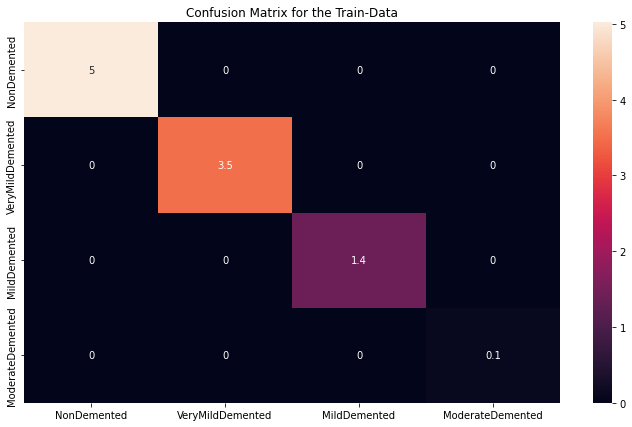

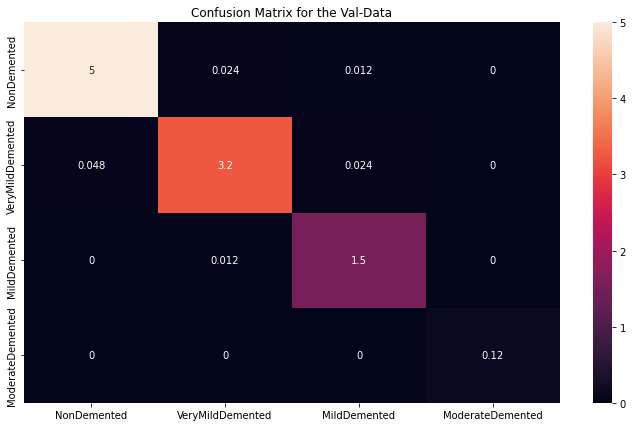

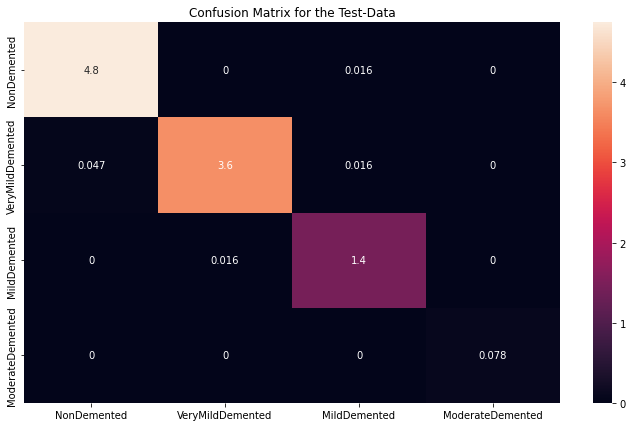

In [36]:
#Ausgaben der Classification Reports und Confusion-Matrizen für Trainings-, Validation- und Test-Datensatz
model.get_classification_report(train_loader, classes, "Train-Data")
print()

model.get_classification_report(val_loader, classes, "Val-Data")
print()

model.get_classification_report(test_loader, classes, "Test-Data")

predicted class;  NonDemented
actual class:  VeryMildDemented


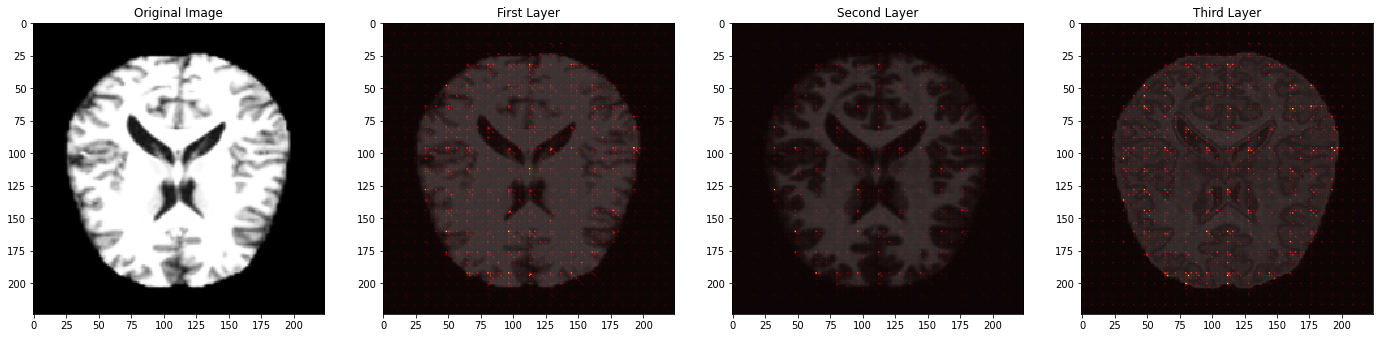

In [38]:
#Anzeigen der Activierungs-Funktion-Gradienten für ein zufälliges Bild im Test-Datensatz
#Da diese Methode nicht wirklich aufschlussreich war, wurde sie nicht in der schriftlichen Arbeit forgestellt
random_num = random.randint(0, batch_size-1)
test_batch = next(iter(test_loader))
inp_data, labels = test_batch
labels = labels.to(dtype=torch.float, device=device)
inp_data = inp_data.to(device).requires_grad_(True)

preds = model.forward(inp_data)

criterion = nn.MSELoss()

loss = criterion(preds, labels)
loss.backward()

specificGrad = inp_data.grad.data[random_num]
#calculate saliency
slc = specificGrad.abs()
#normalize to [0..1]
slc = (slc - slc.min()) / (slc.max()- slc.min())
slc_map = slc.cpu()

print("predicted class; ", classes[preds[random_num].argmax(dim=-1).item()])
print("actual class: ", classes[labels[0].argmax(dim=-1).item()])

#plot saliency
fig, ax = plt.subplots(1, 4, figsize=(5, 5))
#set plot size
fig.set_size_inches(24, 24)
#Plot normal image
plt.gray()
ax[0].title.set_text('Original Image')
ax[0].imshow(inp_data[random_num][0].cpu().detach().numpy(), interpolation="nearest")

ax[1].title.set_text('First Layer')
ax[1].imshow(inp_data[random_num][0].cpu().detach().numpy(), interpolation="nearest", alpha=0.9)
ax[1].imshow(slc_map[0], cmap='hot', alpha=.8)

ax[2].title.set_text('Second Layer')
ax[2].imshow(inp_data[random_num][1].cpu().detach().numpy(), interpolation="nearest", alpha=0.9)
ax[2].imshow(slc_map[1], cmap='hot', alpha=.8)

ax[3].title.set_text('Third Layer')
ax[3].imshow(inp_data[random_num][2].cpu().detach().numpy(), interpolation="nearest", alpha=0.9)
ax[3].imshow(slc_map[2], cmap='hot', alpha=.8)

fig.show()

torch.Size([64, 128, 1])


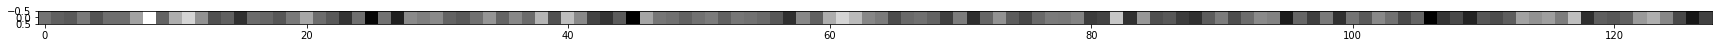

In [39]:
#visualize tokens
tokens = model.tokenConcatenator.class_token
print(tokens.size())
tokens = tokens.cpu().detach().numpy()
#get one row of tokens
tokens_row = tokens[0].reshape(1,128)
plt.figure(figsize=(30, 20))
plt.imshow(tokens_row)

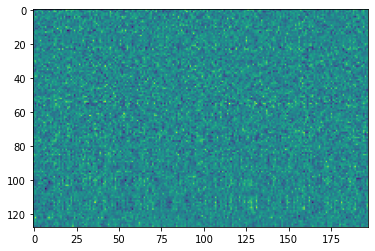

In [40]:
#visualize position embedding
position_embedding = model.positionEmbedding.position_embedding
position_embedding = position_embedding.cpu().detach().numpy()
plt.imshow(position_embedding[0], cmap="viridis")

Total convolution layers: 5
conv_layers


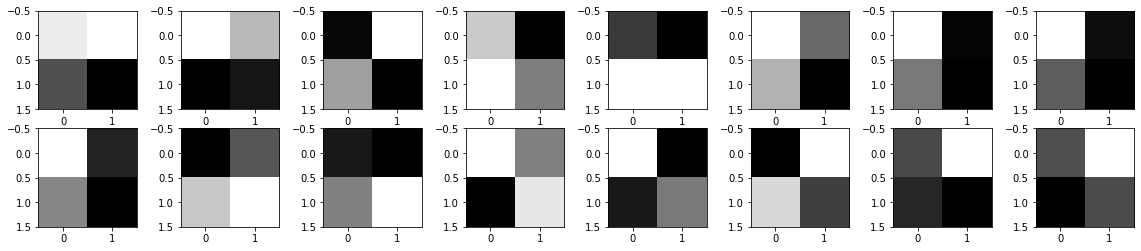

In [41]:
#get random image
random_num = random.randint(0, batch_size-1)
batch = next(iter(train_loader))
inp_data, labels = batch
inp_data = inp_data[0].to(device)


model_weights =[]
conv_layers = []
children = list(model.convNet.children())

counter = 0
#append the conv-layers from the convNet
for i in range(len(children)):
    if type(children[i]) == torch.nn.modules.conv.Conv2d:
        counter += 1
        model_weights.append(children[i].weight)
        conv_layers.append(children[i])

#Append the conv-layer from the patch embedding
counter += 1
model_weights.append(list(model.patchEmbedding.children())[0].weight)
conv_layers.append(list(model.patchEmbedding.children())[0])

        
        
print(f"Total convolution layers: {counter}")
print("conv_layers")

#Visualize Conv-Layer-Filters of first layer
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 7x7 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].cpu().detach().numpy(), cmap='gray')
plt.show()

Layer:  1
Layer-Dimensions:  torch.Size([16, 112, 112])


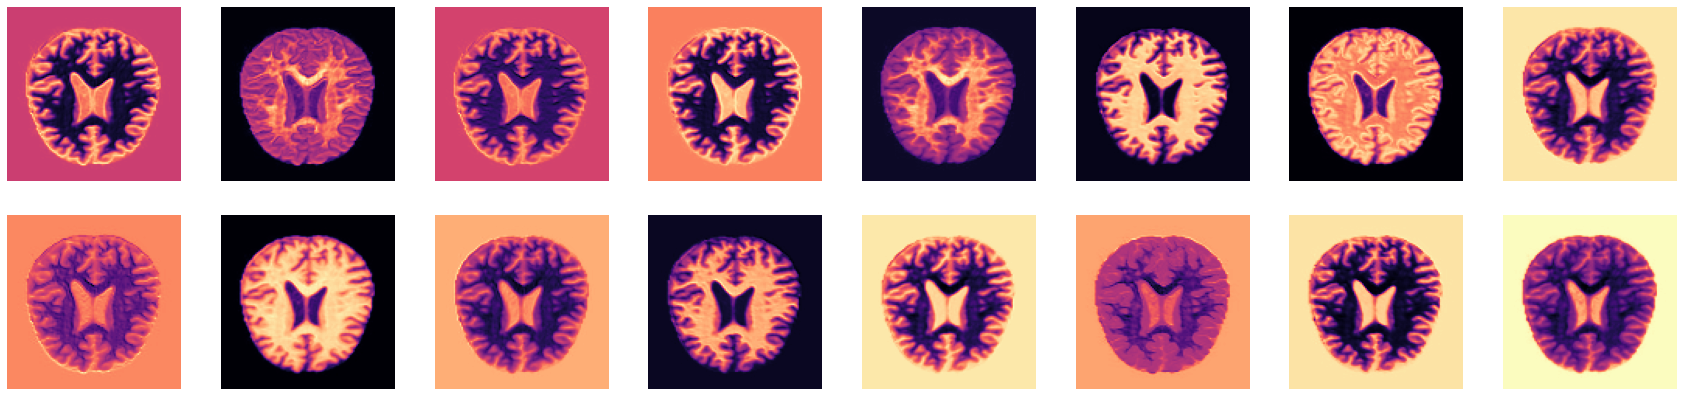

Layer:  2
Layer-Dimensions:  torch.Size([32, 56, 56])


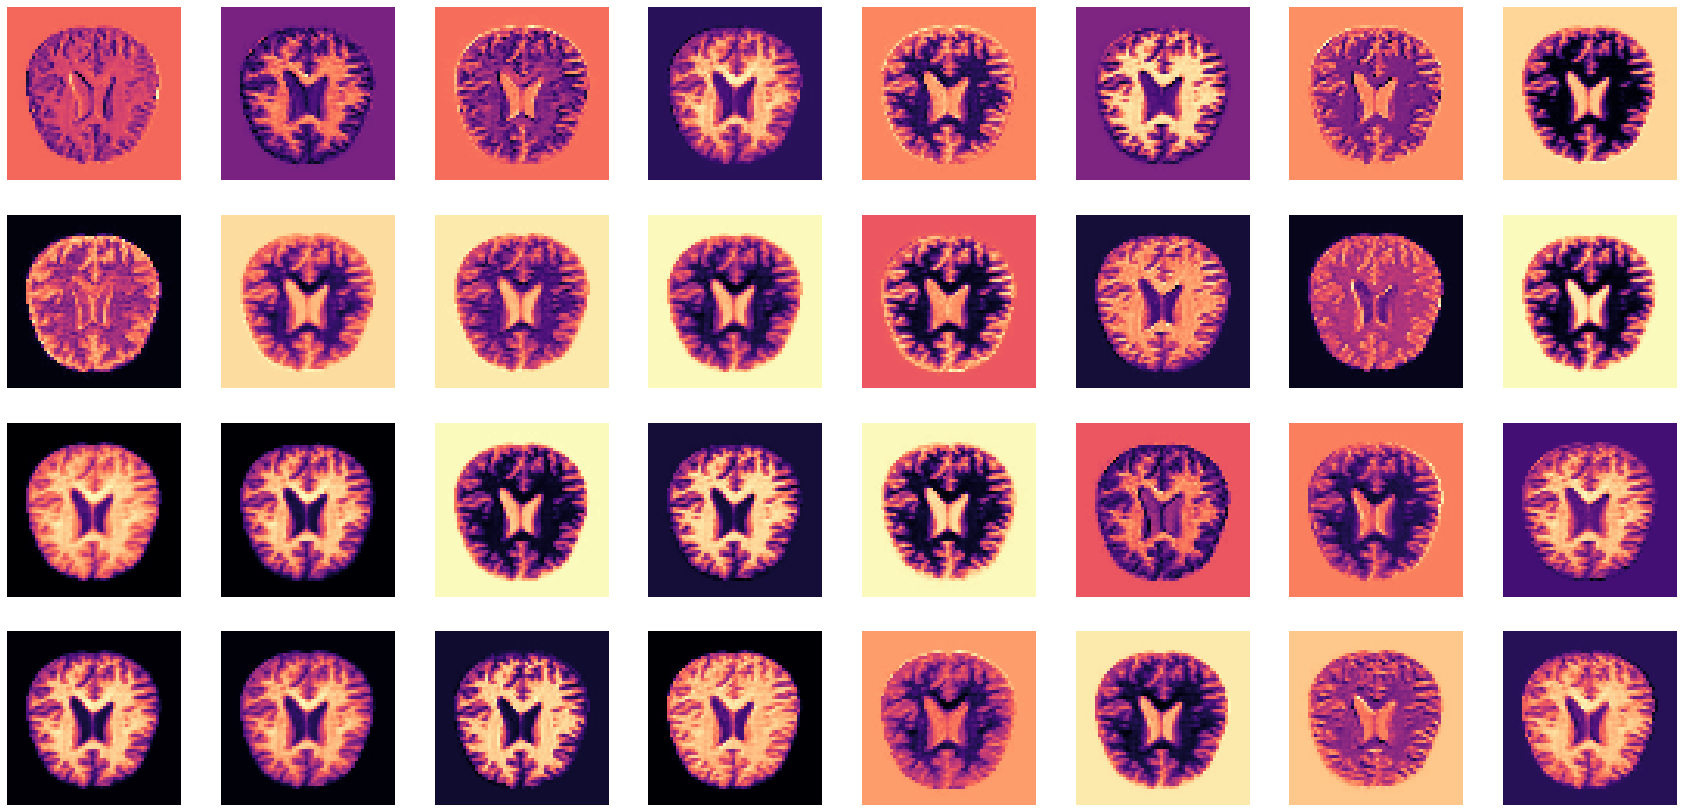

Layer:  3
Layer-Dimensions:  torch.Size([64, 28, 28])


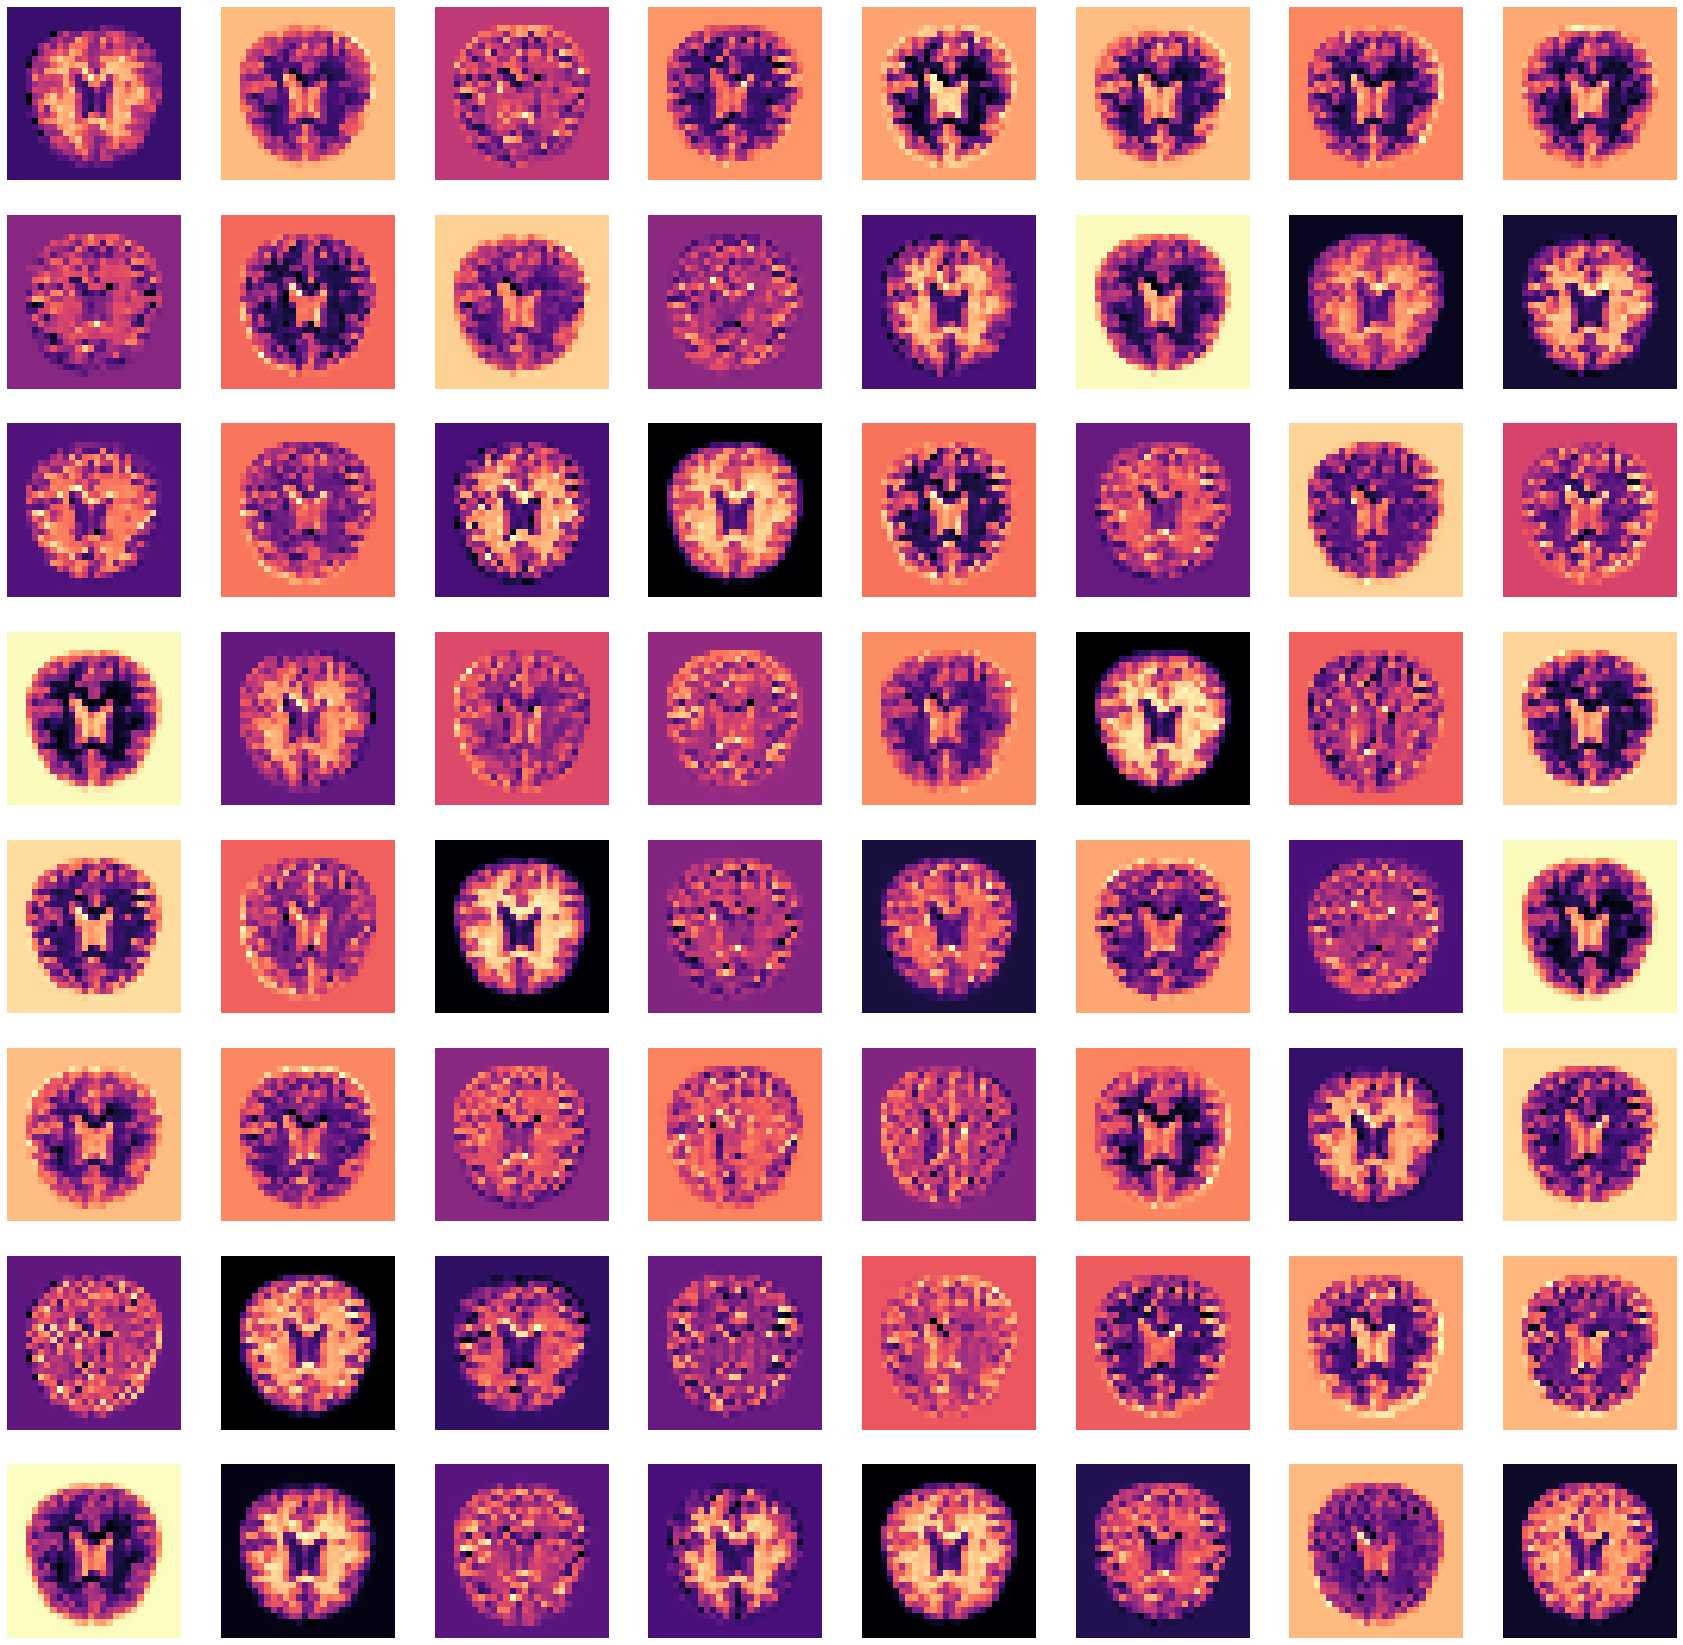

Layer:  4
Layer-Dimensions:  torch.Size([128, 14, 14])


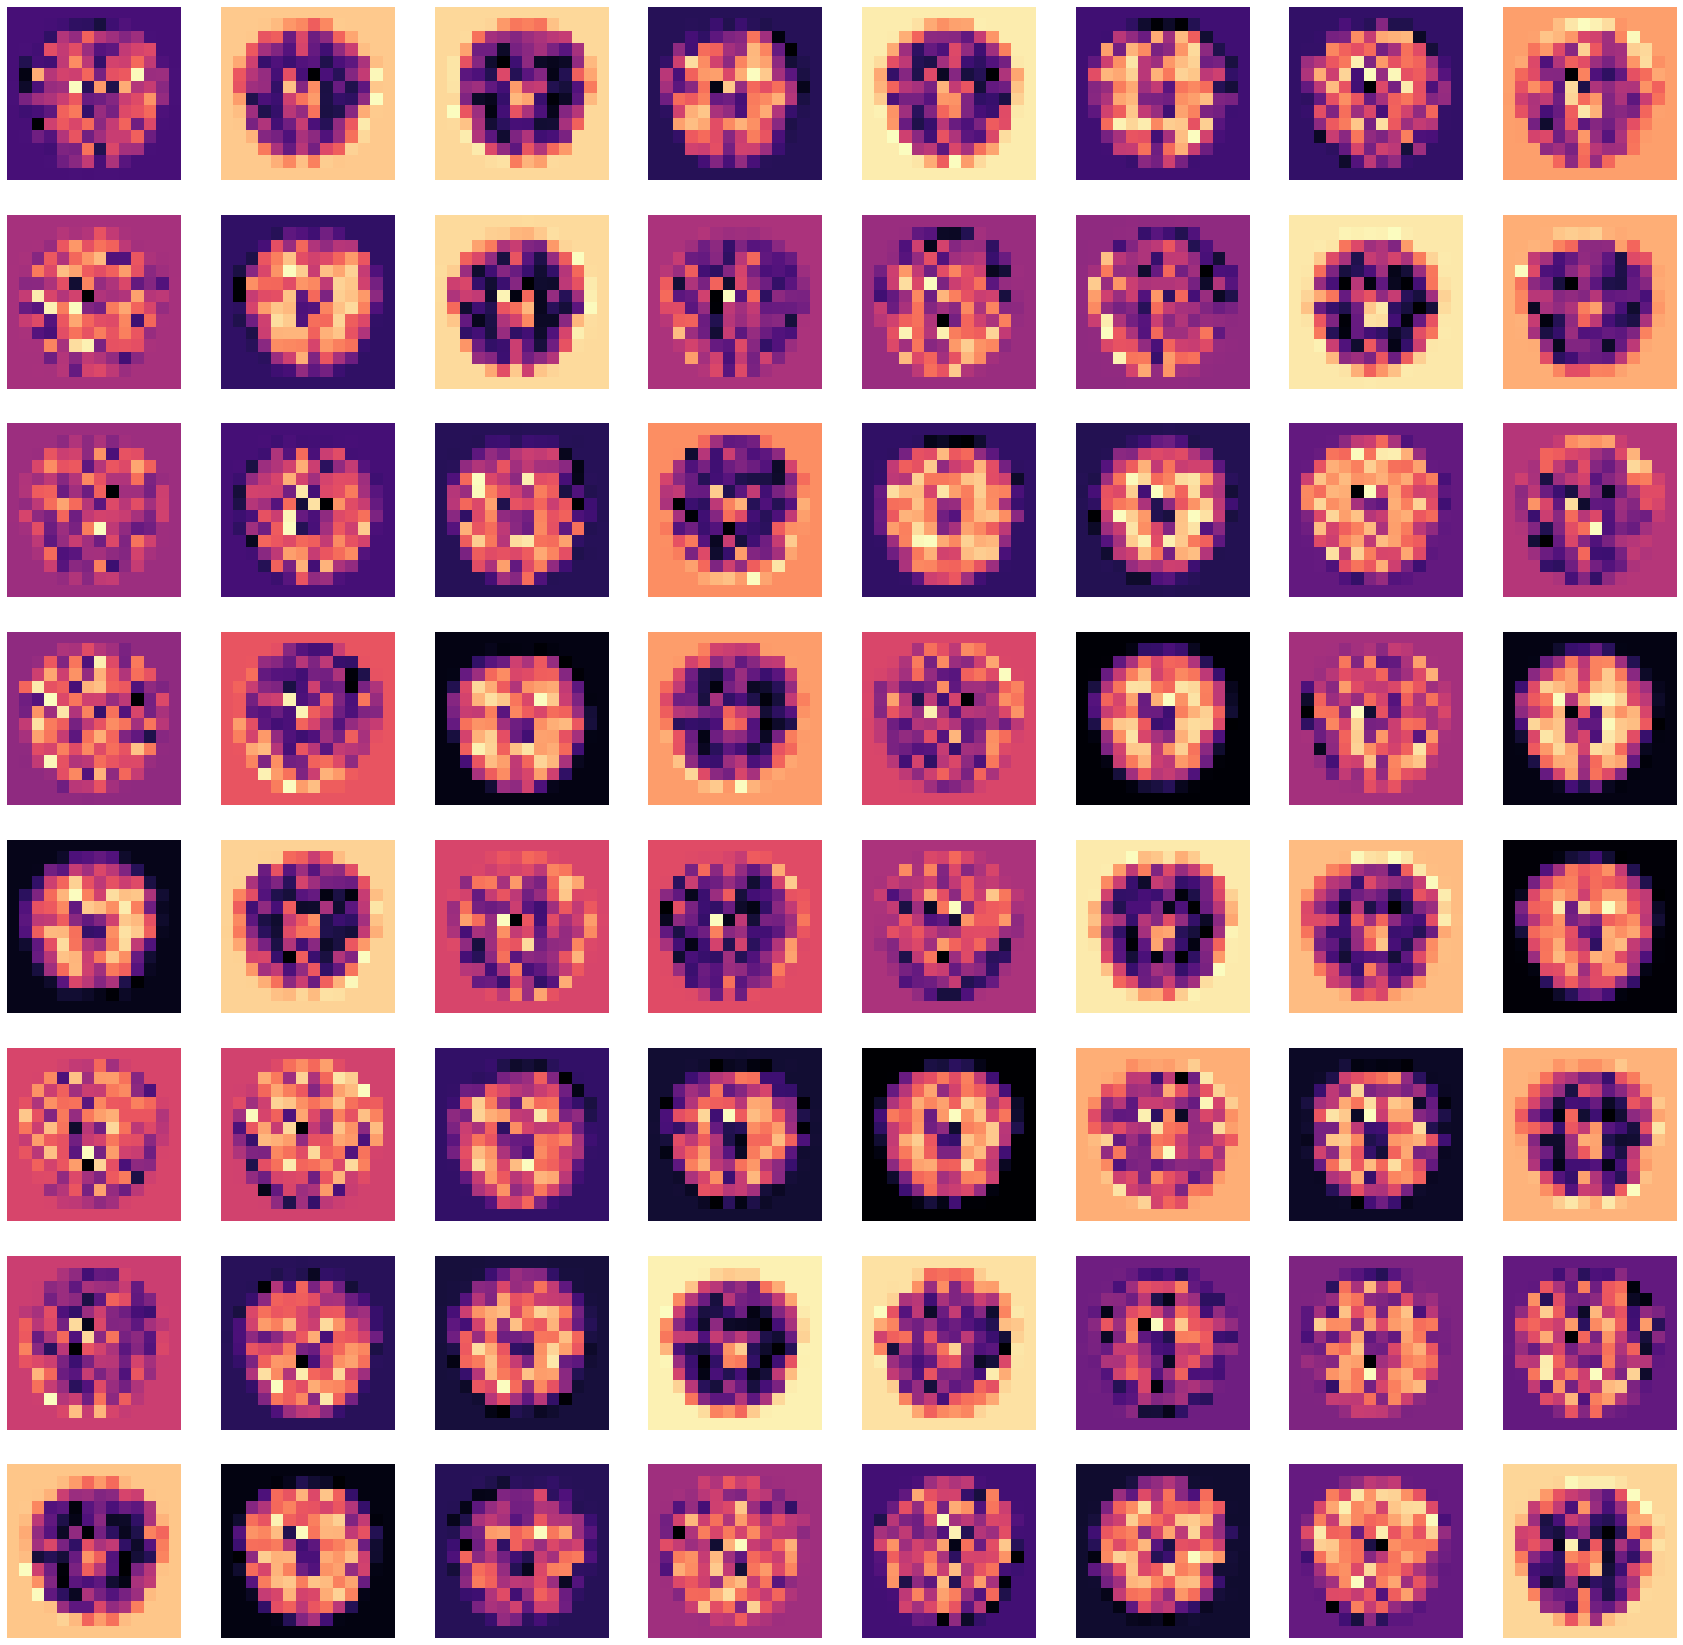

Layer:  5
Patch-Embedding Convolutional-Layer
Layer-Dimensions:  torch.Size([128, 14, 14])


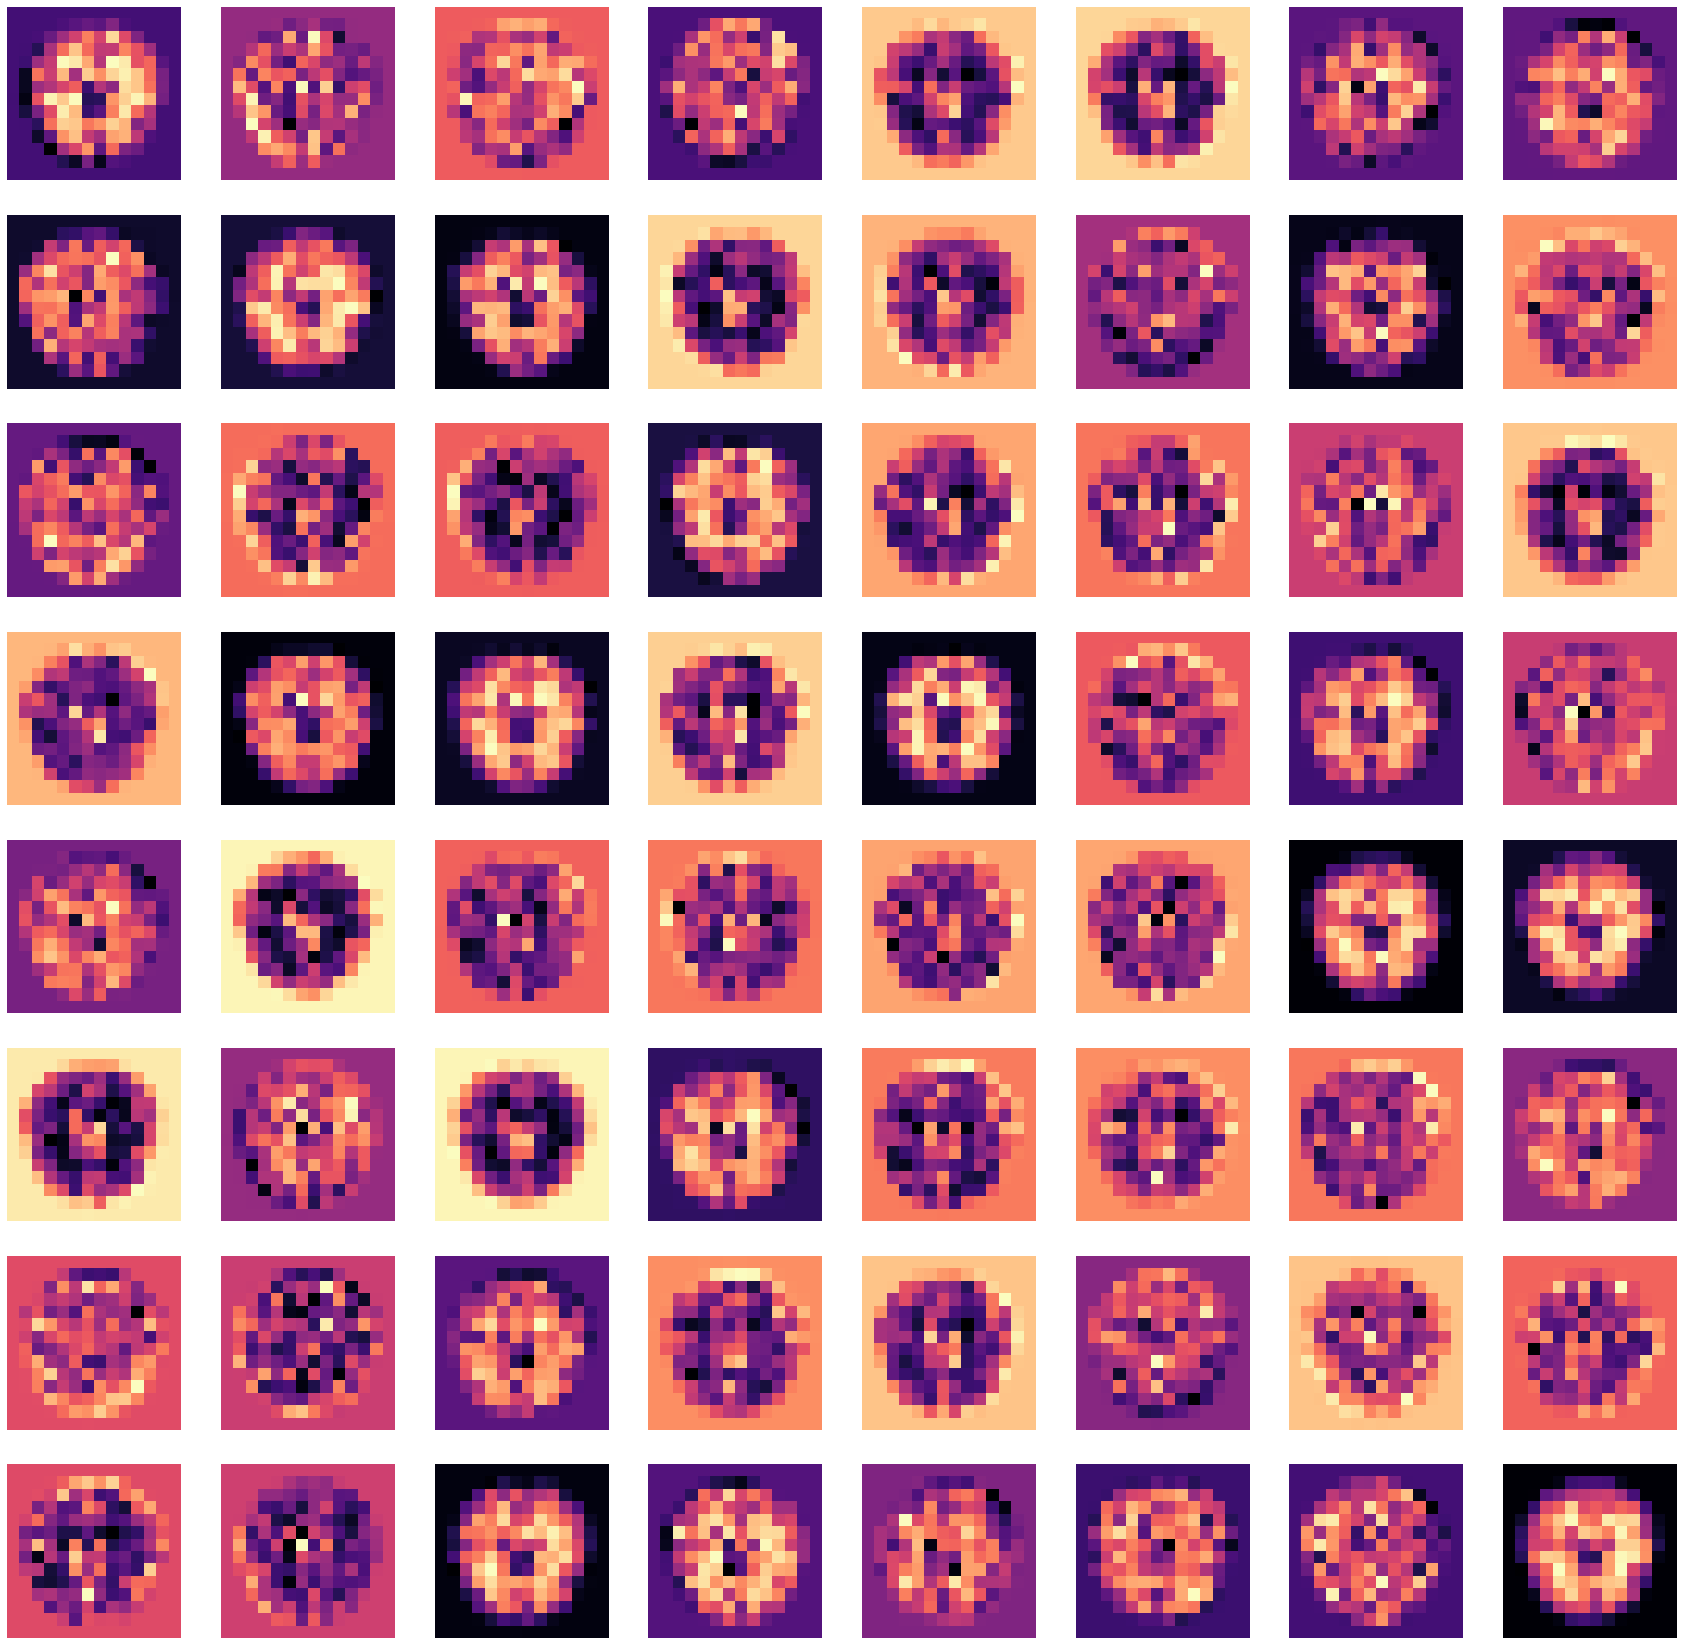

In [42]:
results = [conv_layers[0](inp_data)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

for num_layer in range(len(outputs)):
    plt.figure(figsize=(30, 30))
    layer_viz = outputs[num_layer]
    #print(outputs[num_layer].size())
    layer_viz = layer_viz.data
    print("Layer: ", num_layer+1)
    if num_layer+1 == 5:
        print("Patch-Embedding Convolutional-Layer")
    print("Layer-Dimensions: ",layer_viz.size())
    for i, filter in enumerate(layer_viz):
        if i == 64: # we will visualize only 8x8 blocks from each layer
            break
        plt.subplot(8, 8, i + 1)
        plt.imshow(filter.cpu().detach().numpy(), cmap='magma')
        plt.axis("off")
    plt.show()

<h4>Grad-Cam</h4>

Actual Label:  VeryMildDemented
Predicted Label:  VeryMildDemented


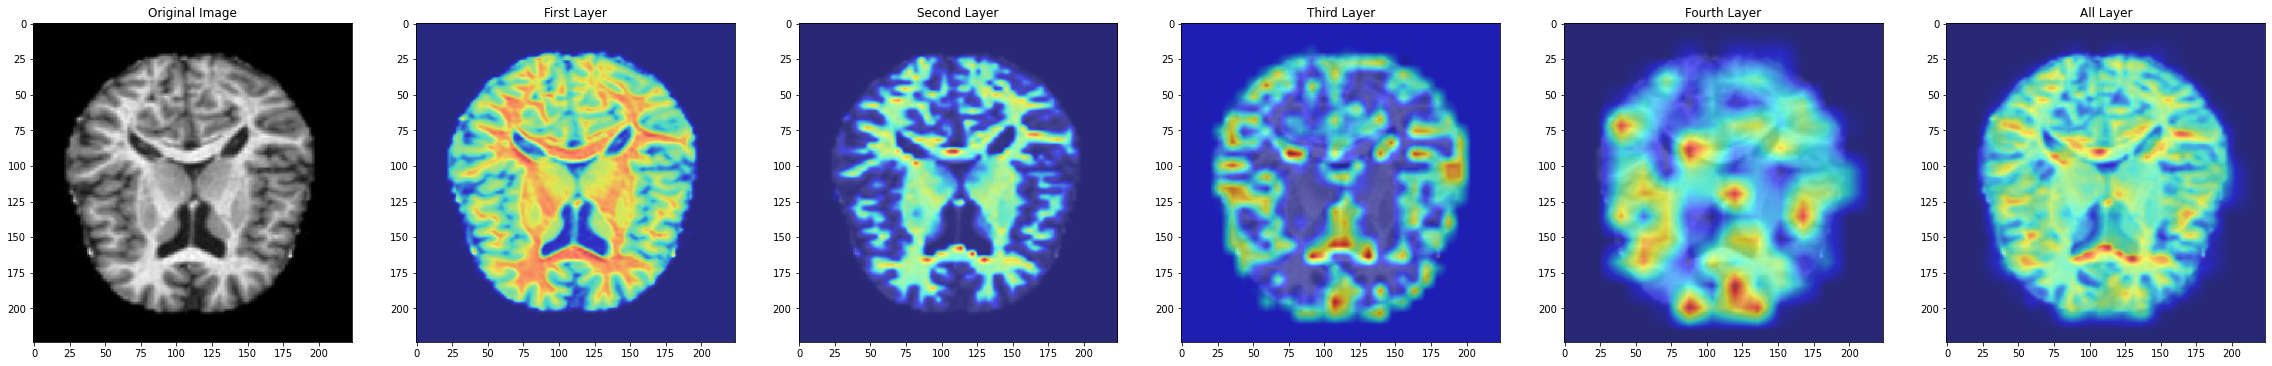

In [46]:
random_num = random.randint(0, batch_size-1)
def get_cam(model, x, target_layers):
    cam = GradCAM(model=model, target_layers=target_layers)
    
    grayscale_cam = cam(input_tensor=x)
    return grayscale_cam

batch = next(iter(test_loader))
inp_data, labels = batch

inp_data = torch.Tensor(inp_data).to(torch.float).to(device)

target_layers = [model.convNet.conv1, model.convNet.conv2, model.convNet.conv3, model.convNet.conv4]

print("Actual Label: ", classes[labels[random_num].argmax()])
print("Predicted Label: ", classes[model(inp_data)[random_num].argmax()])

alpha_original = 0.6
alpha_maps = .6

fig, ax = plt.subplots(1, 6, figsize=(5, 5))

fig.set_size_inches(40, 40)

ax[0].title.set_text('Original Image')
ax[0].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest")

ax[1].title.set_text('First Layer')
ax[1].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[1].imshow(get_cam(model, inp_data, target_layers=target_layers[:1])[random_num, :], alpha=alpha_maps, cmap="jet")

ax[2].title.set_text('Second Layer')
ax[2].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[2].imshow(get_cam(model, inp_data, target_layers=target_layers[1:2])[random_num, :], alpha=alpha_maps, cmap="jet")

ax[3].title.set_text('Third Layer')
ax[3].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=.7)
ax[3].imshow(get_cam(model, inp_data, target_layers=target_layers[2:3])[random_num, :], alpha=alpha_maps, cmap="jet")

ax[4].title.set_text('Fourth Layer')
ax[4].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[4].imshow(get_cam(model, inp_data, target_layers=target_layers[3:4])[random_num, :], alpha=alpha_maps, cmap="jet")

ax[5].title.set_text('All Layer')
ax[5].imshow(np.array(rgb2gray(inp_data[random_num].cpu())), interpolation="nearest", alpha=alpha_original)
ax[5].imshow(get_cam(model, inp_data, target_layers=target_layers[:])[random_num, :], alpha=alpha_maps, cmap="jet")

plt.show()

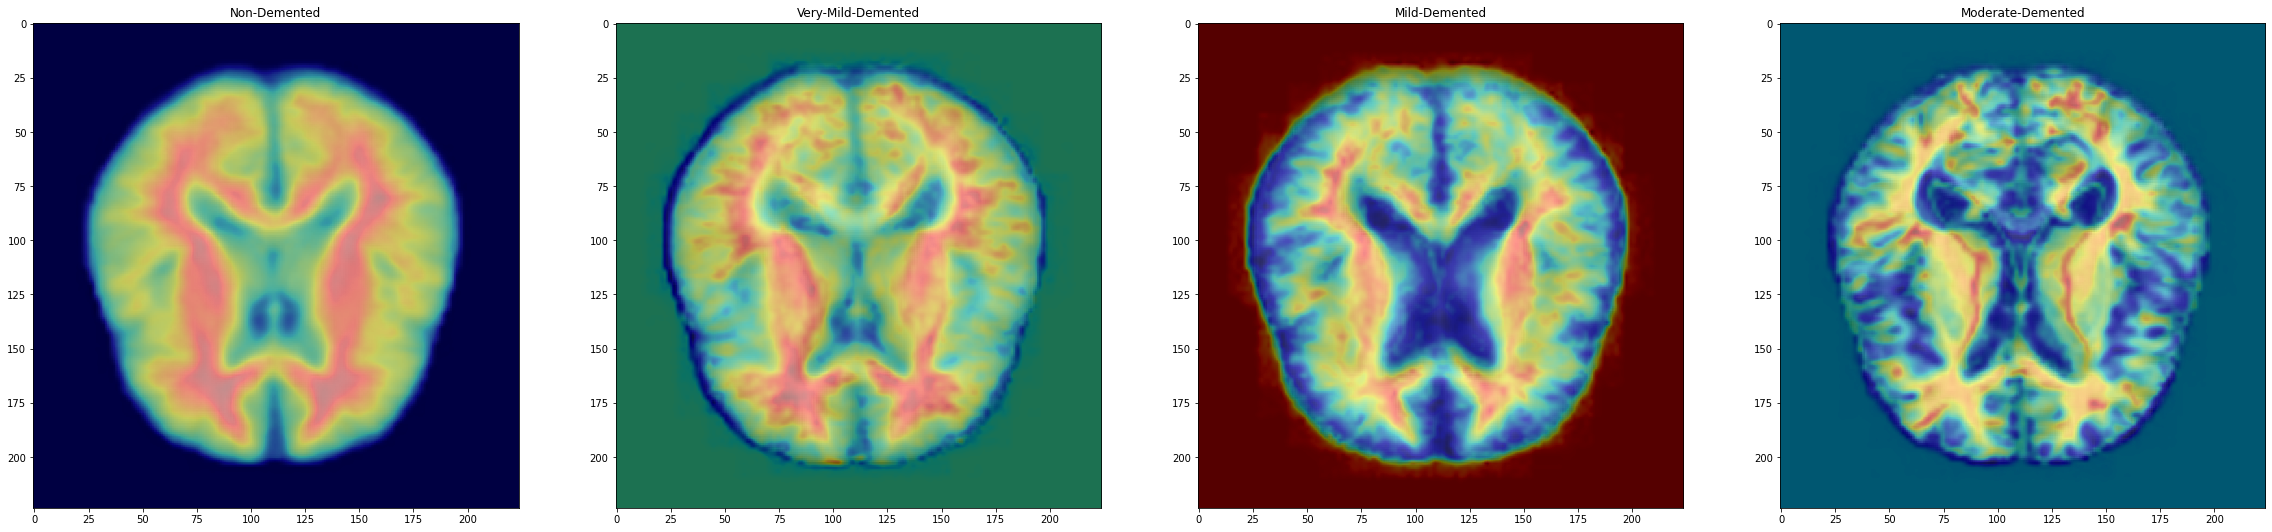

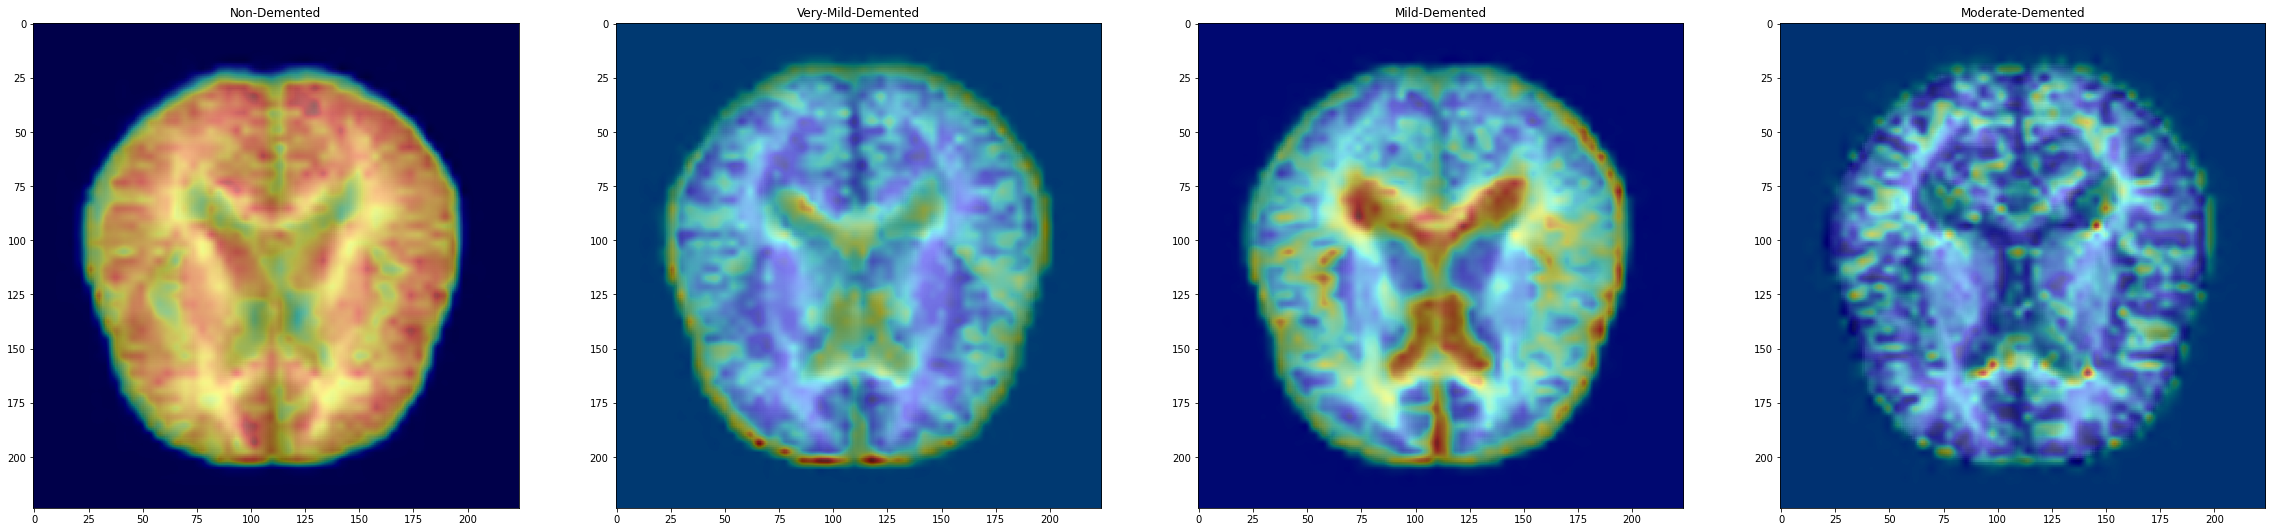

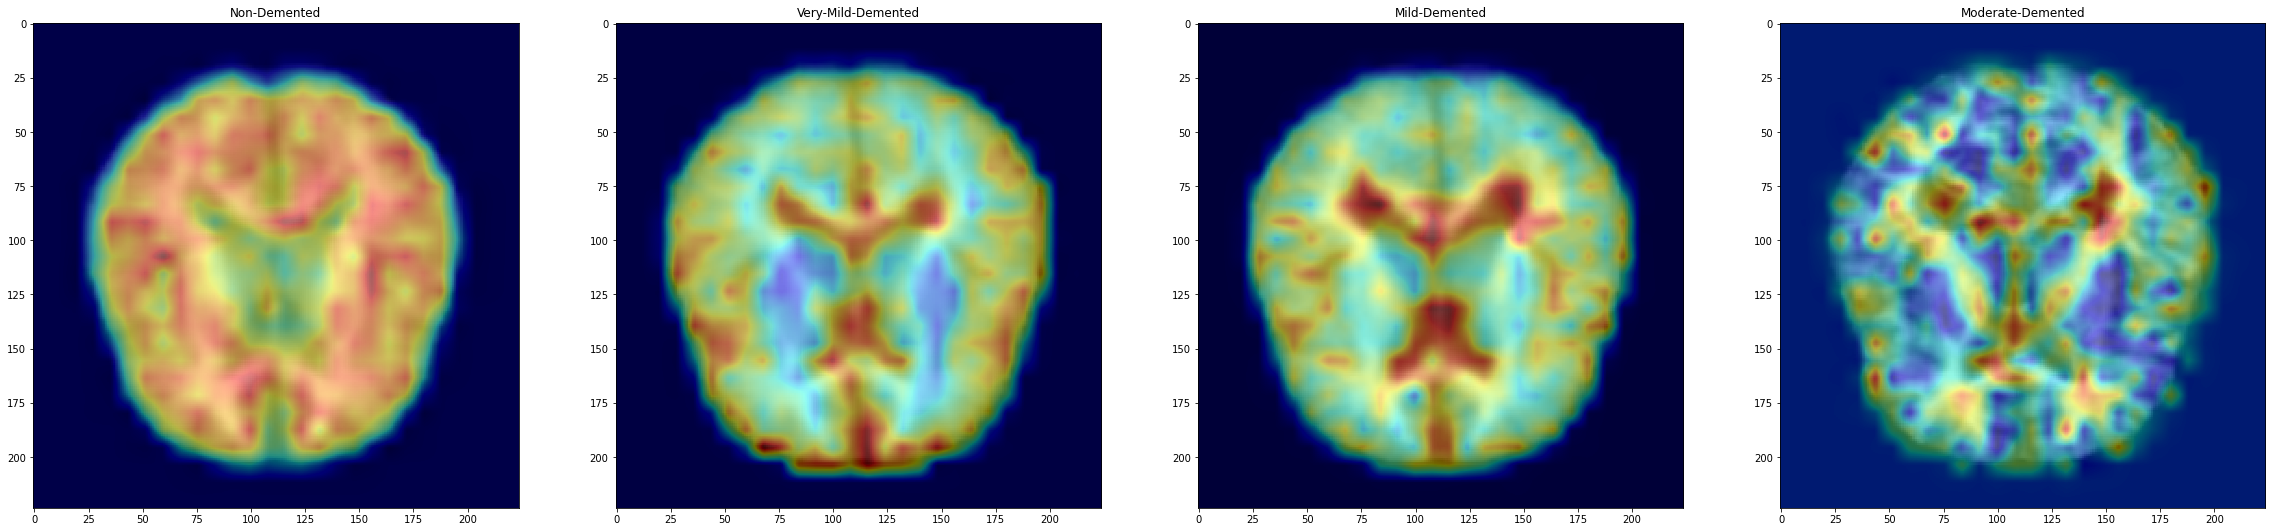

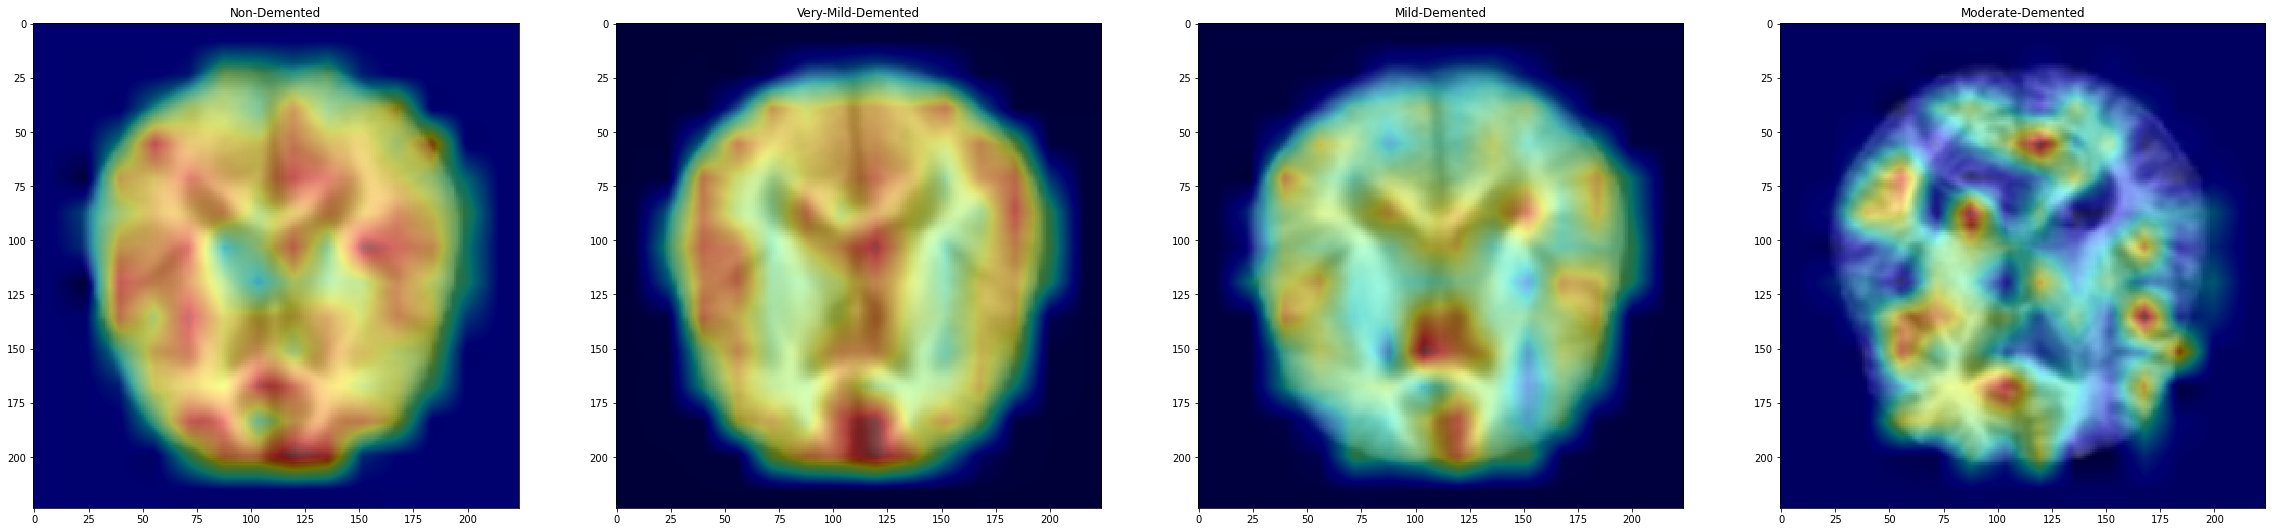

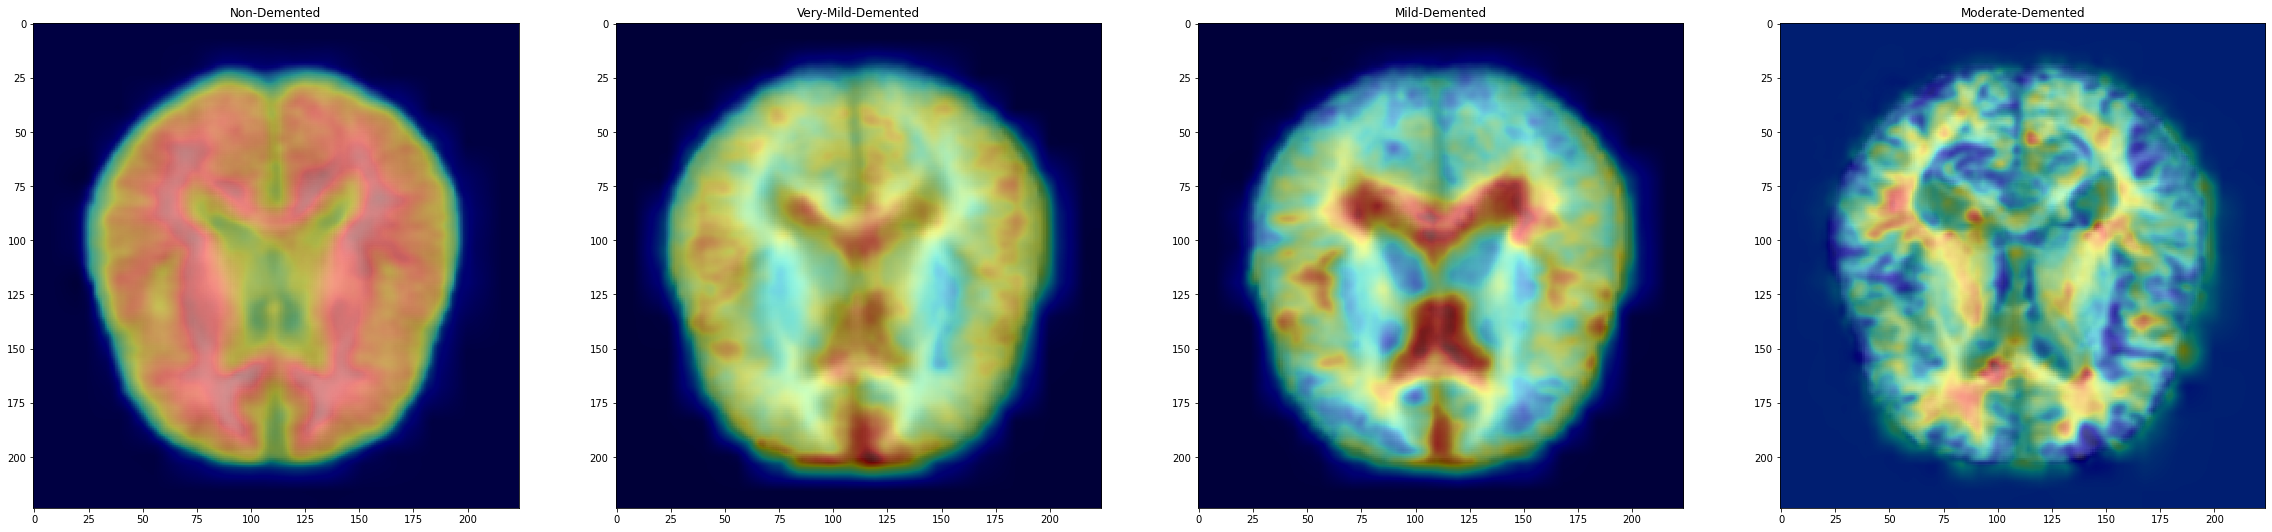

In [44]:
#iterate through the test_loader to get a mean attention maps from the individual layers and the whole model

#create numpy arrays that safe the data for the individual labels

def get_grad_cam_for_individual_layer_for_specific_layer(targeted_layers, alpha_original, alpha_cam):
    cam_nonDemented = np.zeros([224, 224])
    cam_veryMildDemented = np.zeros([224, 224])
    cam_mildDemented = np.zeros([224, 224])
    cam_moderateDemented = np.zeros([224, 224])
    
    img_nonDemented = np.zeros([224, 224])
    img_veryMildDemented = np.zeros([224, 224])
    img_mildDemented = np.zeros([224, 224])
    img_moderateDemented = np.zeros([224, 224])
    
    count_non = 0
    count_veryMild = 0
    count_mild = 0
    count_moderate = 0

    for inp_data, labels in test_loader:
        inp_data = torch.Tensor(inp_data).to(torch.float).to(device)
        batch_cam = get_cam(model, inp_data, target_layers=targeted_layers)
        for i in range(batch_cam.shape[0]):
            label = labels[i].tolist()
            if label == [1, 0, 0, 0]:
                img_nonDemented += rgb2gray(inp_data[i].cpu())
                cam_nonDemented += batch_cam[i]
                count_non += 1
            elif label == [0, 1, 0, 0]:
                img_veryMildDemented += rgb2gray(inp_data[i].cpu())
                cam_veryMildDemented += batch_cam[i]
                count_veryMild += 1
            elif label == [0, 0, 1, 0]:
                img_mildDemented += rgb2gray(inp_data[i].cpu())
                cam_mildDemented += batch_cam[i]
                count_mild += 1
            elif label == [0, 0, 0, 1]:
                img_moderateDemented += rgb2gray(inp_data[i].cpu())
                cam_moderateDemented += batch_cam[i]
                count_moderate += 1

    #average all cams
    cam_nonDemented = cam_nonDemented / count_non
    cam_veryMildDemented = cam_veryMildDemented / count_veryMild
    cam_mildDemented = cam_mildDemented / count_mild
    cam_moderateDemented = cam_moderateDemented / count_moderate
    
    img_nonDemented = img_nonDemented / count_non
    img_veryMildDemented = img_veryMildDemented / count_veryMild
    img_mildDemented = img_mildDemented / count_mild
    img_moderateDemented = img_moderateDemented / count_moderate

    #plot the averaged cams
    fig, ax = plt.subplots(1, 4, figsize=(5, 5))

    fig.set_size_inches(40, 40)

    ax[0].title.set_text('Non-Demented')
    ax[0].imshow(img_nonDemented, interpolation="nearest", alpha=alpha_original)
    ax[0].imshow(cam_nonDemented, alpha=alpha_cam, cmap="jet")

    ax[1].title.set_text('Very-Mild-Demented')
    ax[1].imshow(img_veryMildDemented, interpolation="nearest", alpha=alpha_original)
    ax[1].imshow(cam_veryMildDemented, alpha=alpha_cam, cmap="jet")

    ax[2].title.set_text('Mild-Demented')
    ax[2].imshow(img_mildDemented, interpolation="nearest", alpha=alpha_original)
    ax[2].imshow(cam_mildDemented, alpha=alpha_cam, cmap="jet")

    ax[3].title.set_text('Moderate-Demented')
    ax[3].imshow(img_moderateDemented, interpolation="nearest", alpha=alpha_original)
    ax[3].imshow(cam_moderateDemented, alpha=alpha_cam, cmap="jet")

    
target_layers = [model.convNet.conv1, model.convNet.conv2, model.convNet.conv3, model.convNet.conv4]

#first layer
get_grad_cam_for_individual_layer_for_specific_layer(target_layers[0:1], alpha_original=1, alpha_cam=.45)

#second layer
get_grad_cam_for_individual_layer_for_specific_layer(target_layers[1:2], alpha_original=1, alpha_cam=.45)

#third layer
get_grad_cam_for_individual_layer_for_specific_layer(target_layers[2:3], alpha_original=1, alpha_cam=.45)

#fourth layer
get_grad_cam_for_individual_layer_for_specific_layer(target_layers[3:4], alpha_original=1, alpha_cam=.45)

#all layer
get_grad_cam_for_individual_layer_for_specific_layer(target_layers[:], alpha_original=1, alpha_cam=.45)

<h4>Attention-Maps</h4>

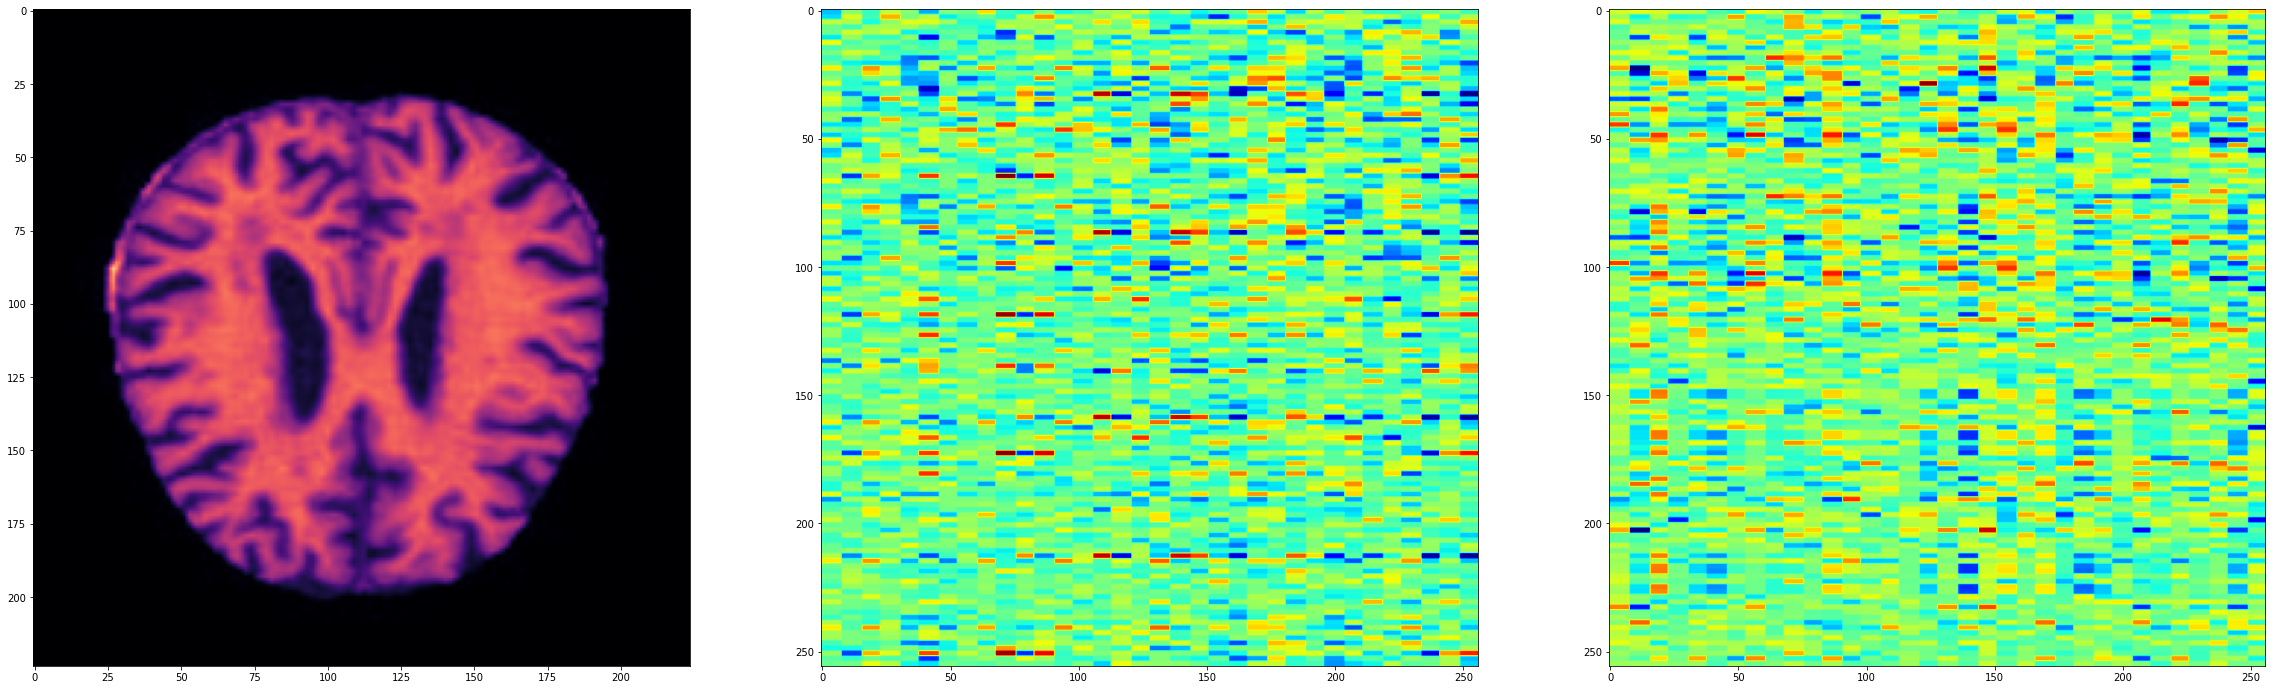

In [45]:
pick_img = random.randint(0, batch_size-1)

inp_data, labels = next(iter(test_loader))

attention_maps = model.get_attention_maps(inp_data.to(device).to(torch.float))

fig, ax = plt.subplots(1, 3, figsize=(5, 5))

fig.set_size_inches(40, 40)

ax[0].imshow(inp_data[pick_img].transpose(0, 1).transpose(1, 2)[:, :, :3])

for count, map in enumerate(attention_maps):
    map = map[pick_img]
    interp = F.interpolate(map.view(1, 1, 9, 128, 34), (1, 256, 256), mode='nearest')
    ax[count+1].imshow(interp.view(256, 256).cpu().detach().numpy(), cmap="jet")
